## Онлайн выпуклая оптимизация

### Общие принципы

Задачи онлайн выпуклой оптимизации можно рассматривать как игру, в которой есть онлайн-игрок, принимающий решения, и противник, который пытается ему помешать. На каждой итерации игрок, основываясь на предыдущей истории игры, выбирает какое-то решение из допустимого множества. После этого становится известна функция потерь, которая каждому решению ставит в соответствие некоторое число, и по ней вычисляется потеря игрока на текущей итерации. Функция потерь своя для каждой итерации, заранее игрок её не знает. Она, впрочем, равномерно ограничена — иначе противник получал бы неограниченную свободу действий и мог бы делать потери сколь угодно большими.

Более формально это можно изложить так. Пусть множество решений — это выпуклое множество $\mathcal{K} \subseteq \mathrm{R}^n$. На $t$-й итерации игрок выбирает решение — точку из $x_t \in \mathcal{K}$. После этого ему становится известна очередная функция потерь $f_t \in \mathcal{F}$, где $\mathcal{F}$ — равномерно ограниченное множество выпуклых функций из $\mathcal{K}$ в $\mathbb{R}$. Потери, понесённые игроком на данном ходу (они же называются стоимостью хода) — это $f_t(x_t)$. Всего в игре $T$ итераций.

Задача игрока, разумеется, состоит в минимизации потерь. Строго говоря, мы будем минимизировать следующую функцию:
$$
    regret_T(\mathcal{A}) = \sup\limits_{\{f_1, \dots, f_T\} \subseteq \mathcal{F}} \left\{ \sum\limits_{i = 1}^T f_t(x_t) - \min\limits_{x \in \mathcal{K}} \sum\limits_{i = 1}^T f_t(x) \right\}, 
$$
которая называется функцией потерь алгоритма $\mathcal{A}$ на $T$ итерациях и представляет собой верхнюю оценку ($\sup$ берётся по всевозможным наборам из $T$ функций из $\mathcal{F}$) разности потерь, понесённых алгоритмом, и потерь в случае, когда наилучшим образом выбирается какое-то фиксированное решение.

Для дальнейшего использования введём обозначение: $\Delta_n = \left\{ x \in \mathbb{R}^n \text{ | } x_i \geqslant 0 \: \forall \; i \text{ и } \sum\limits_{i = 1}^n x_i = 1 \right\}$.

### Задача формирования портфеля

Задача формирования портфеля — по сути, игра на бирже. На каждой итерации игрок распределяет имеющиеся у него финансы по различным активам: на $t$-й итерации он выбирает точку $x_t \in \Delta_n$ так, что $i$-я её координата $x_{ti}$ — доля финансов игрока, которую он хочет вложить в $i$-й актив. После того, как вложения сделаны, т.е. точка $x_t \in \Delta_n$ выбрана, игрок узнаёт, как изменилась стоимость активов между текущей и следующей итерациями. Пусть $r_{ti} \in \mathbb{R_{++}}$ — отношение новой стоимости $i$-го актива к старой, показывающее, во сколько раз стоимость увеличилась или упала. Тогда по итогу торгов между итерациями $t$ и $t + 1$ состояние игрока увеличится в $r_t^Tx_t$ раз, где $r_t = (r_{t1}, r_{t2}, \dots, r_{tn})^T$ — вектор со стоимостями активов. Поэтому логично функцию потерь для каждой итерации определить как $-\ln(r_t^Tx_t)$. Задача же игрока состоит в соответствии с вышеизложенным в минимизации функции потерь всего алгоритма, то есть разности
\begin{equation}\label{regret}
    \max\limits_{x^* \in \Delta_n} \sum\limits_{i = 1}^T \ln(r_t^Tx^*) - \sum\limits_{i = 1}^T \ln(r_t^Tx_t).
\end{equation}
Стратегии, в которой $x^*$ фиксировано, соответствуют перераспределению ресурсов одинаковым образом после каждых торгов. Минимизация же функции потерь соответствует максимизации отношения прибыли, полученной алгоритмом, к прибыли, полученной по лучшей из таких стратегий.

## Методы решения

### Метод проекции градиента

Понадобится функция, вычисляющая проекцию точки $с \in \mathbb{R}^n$ на $n$-мерный симплекс (ранее он был обозначен как $\Delta_n$). Реализуем её. Использовать будем алгоритм, описанный в статье В.Н.Малоземова и Г.Ш.Тамасяна ([ссылка на статью](http://www.apmath.spbu.ru/ru/staff/tamasyan/publ/publ1.pdf), пункт 5, стр. 6).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect_right
%matplotlib inline


eps = 1e-12

In [2]:
def project(c):
    n = len(c)
    a = np.hstack((np.zeros(1), np.sort(-c)))
    f = np.zeros(n + 1)
    for i in range(1, n):
        f[i + 1] = f[i] + i * (a[i + 1] - a[i])
    k0 = bisect_right(f, 1) - 1
    addition = a[k0] + (1 - f[k0]) / k0
    return np.maximum(addition + c, np.zeros(n))

print(project(np.array([-1, 1, 0, -1, 0, 2 / 3])))

[0.         0.66666667 0.         0.         0.         0.33333333]


Сам же метод проекции градиента таков:
1. На вход получаем: 
    * выпуклое множество $\mathcal{K} \subseteq \mathrm{R}^d$
    * количество итераций $T$
    * начальную точку $x_1 \in \mathcal{K}$
    * размеры шагов $\{ \eta_t \}$
2. Всего алгоритм проделывает T итераций. Пусть $t$ — номер текущей итерации.
3. "Делаем ход" $x_t$, видим потерю $f_t(x_t)$.
4. Вычисляем следующую точку, как в обычном градиентом методе для функции $f_t$: $y_{t + 1} = x_t - \eta_t \nabla f_t(x_t)$
5. Проецируем её на наше множество: $x_{t + 1} = \Pi_{\mathcal{K}}(y_{t + 1})$
6. Увеличиваем t, возвращаемся к пункту 2.

Введём несколько обозначений. Обозначим $D$ верхнюю оценку диаметра множества $\mathcal{K}$, т.е. такое число, что 
$$
    \forall \; x, y \in \mathcal{K} \; \|x - y\| \leqslant D.
$$
Также будем считать, что $\exists G \in \mathbb{R}_{++}^d$ такое, что для всех функций $f_t \in \mathcal{F}$ выполнено неравенство $\|\nabla{f_t(x)}\| \leqslant G \; \forall \: x \in \mathcal{K}$, то есть все функции $f_t$ липшицевы с константой $G$: $|f_t(x) - f_t(y)| \leqslant G \|x - y\|$.

**Теорема 1.**
Метод проекции градиента с шагом $\eta_t = \frac{D}{G\sqrt{t}}$ гарантирует следующую оценку для функции потерь:
$$
    regret_T = \sum\limits_{i = 1}^T f_t(x_t) - \min\limits_{x^* \in \mathcal{K}} \sum\limits_{i = 1}^T f_t(x^*) \leqslant \frac{3}{2}GD\sqrt{T}.
$$

Более того, оказывается, что эта оценка в общем случае качественно улучшена быть не может. А именно, верна следующая

**Теорема 2.**
Для любого алгоритма онлайн выпуклой оптимизации потери в худшем случае составляют $\Omega(DG\sqrt{T})$.

Создадим таблицу $R \in \mathbb{R}^{T \times d}$, $t$-я строка которой суть $r_t$ — вектор отношений цен активов на итерациях $t$ и $t + 1$ (т.е. $r_{ti} = \frac{cost_i(t + 1)}{cost_i(t)}$).

In [3]:
def generate_table(d, T):
    R = np.zeros((T, d))
    up = np.arange(d) + 1
    down = 1 / up
    for i in range(T):
        if i % 2:
            R[i] = np.random.permutation(down)
        else:
            R[i] = np.random.permutation(up)
    return R

print(generate_table(5, 6))

[[1.         4.         2.         3.         5.        ]
 [0.5        0.33333333 0.25       1.         0.2       ]
 [3.         1.         4.         2.         5.        ]
 [0.5        0.33333333 0.2        0.25       1.        ]
 [3.         4.         1.         2.         5.        ]
 [0.5        0.33333333 1.         0.25       0.2       ]]


Как видим из (\ref{regret}), для вычисления функции потерь необходимо знать $\max\limits_{x^* \in \Delta_n} \sum\limits_{i = 1}^T \ln(r_t^Tx^*)$, т.е. наилучшее фиксированное решение. Его найдём обычным методом проекции градиента, используя липшицевость функции $f(x) = \sum\limits_{i = 1}^T \ln(r_t^Tx)$. Действительно, 
\begin{gathered}
    \nabla f(x) = \sum\limits_{i = 1}^T \frac{r_t}{<r_t, x>} \\
    \|\nabla f(x)\| \leqslant \sum\limits_{i = 1}^T \frac{\|r_t\|}{<r_t, x>} \leqslant \sum\limits_{i = 1}^T \frac{\|r_t\|}{\min\limits_{i = 1 \dots d}r_{ti}}.
\end{gathered}
Это число и возьмём за константу Липшица $L$, а шаг в градиентном методе выберем равным $\frac{1}{L}$.

Далее в коде $f(x) = \sum\limits_{i = 1}^T \ln(<r_t, x>)$, $\mathrm{gradf}(x) = \sum\limits_{i = 1}^T \frac{r_t}{<r_t, x>}$. 

In [4]:
def f(x):
    T = R.shape[0]
    result = 0
    for t in range(T):
        result += np.log(np.dot(R[t], x))
    return result

In [5]:
def gradf(x):
    T = R.shape[0]
    d = R.shape[1]
    result = np.zeros(d)
    for t in range(T):
        result += R[t] / np.dot(R[t], x)
    return result

Функция `calculate_L` вычисляет константу Липшица $L$ для функции $f(x)$, как описано выше.

In [6]:
def calculate_L():
    T = R.shape[0]
    result = 0
    for t in range(T):
        result += np.linalg.norm(R[t]) / np.min(R[t])
    return result

Функция `pg_fixed` применяет офлайн-метод проекции градиента для поиска максимума функции $f$. `x0` в её параметрах — некоторая начальная точка.

In [7]:
def pg_fixed(x0, L):
    x = x0
    iterations = 1000
    for i in range(iterations):
        y = project(x + 1 / L * gradf(x))
        if np.linalg.norm(y - x) < eps:
            break
        x = y
    return f(x)

Объединяет всё на этом этапе функция `calculate_fixed_profit`, которая подсчитывает прибыль на наилучшем фиксированном решении $\max\limits_{x^* \in \Delta_n} \sum\limits_{i = 1}^T \ln(r_t^Tx^*)$, которую мы и хотели получить изначально.

In [8]:
def calculate_fixed_profit(dim):
    L = calculate_L()
    x_init = np.zeros(dim)
    x_init[0] = 1
    return pg_fixed(x_init, L)

Теперь можно, наконец, решать задачу онлайн выпуклой оптимизации. В соответствии с изложенным ранее, функция потерь на итерации $t$ в данной задаче есть $f(x) = \ln(<r_t, x>)$. В коде далее она называется `f_online`, а `gradf_online` — её градиент. Как требуется в **Теореме 1**, выберем шаг $\eta_t = \frac{D}{G\sqrt{t}}$. Для $n$-мерного симплекса $\Delta_n$ диаметр равен $\sqrt{d}$, а константа Липшица (вернее говоря, оценка для неё)
$$
    G = \max\limits_{t \in \{ 1, \dots, T\}} \frac{\|r_t\|}{\min\limits_{i \in \{ 1, \dots, n\}}r_{ti}},
$$
поскольку она должна ограничивать сверху все градиенты, а $\nabla f_t(x) = \frac{r_t}{<r_t, x>}$. Вычислением этой константы занимается функция `calculate_G`.

In [9]:
def f_online(t, x):
    return np.log(np.dot(R[t], x))

In [10]:
def gradf_online(t, x):
    return R[t] / np.dot(R[t], x)

In [11]:
def calculate_G():
    T = R.shape[0]
    return np.max(np.array([np.linalg.norm(R[t]) / np.min(R[t]) for t in range(T)]))

In [12]:
def pg_online(x0, G):
    x = x0
    profit = 0
    d = R.shape[1]
    T = R.shape[0]
    for t in range(T):
        profit += f_online(t, x)
        x = project(x + np.sqrt(d / (t + 1)) / G * gradf_online(t, x))
    return profit

Функция `calculate_online_profit` объединяет имеющиеся функции, подсчитывая выгоду игрока, применяющего наш алгоритм онлайн проекции градиента.

In [13]:
def calculate_online_profit(dim):
    G = calculate_G()
    x_init = np.zeros(dim)
    x_init[0] = 1
    return pg_online(x_init, G)

### Зависимость от исходных данных

Посмотрим, как зависит функция потерь алгоритма от количества итераций, а время работы — от размерности пространства.

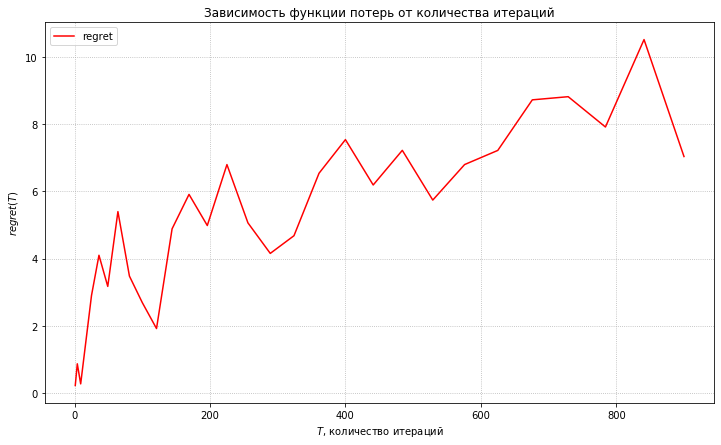

In [19]:
dimension = 5
max_T = 30
x_initial = [1, 0, 0, 0, 0]
T_grid = (np.arange(max_T) + 1) ** 2
diff_grid = np.zeros(max_T)
G_last = 0

for i in range(max_T):
    T = T_grid[i]
    R = generate_table(dimension, T)
    best_fixed_profit = calculate_fixed_profit(dimension)
    our_profit = calculate_online_profit(dimension)
    diff_grid[i] = best_fixed_profit - our_profit
    if i == max_T - 1:
        G_last = calculate_G()
        
regret_upper_bound = 3 / 2 * np.sqrt(dimension) * G_last * np.sqrt(T_grid)
    
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.plot(T_grid, diff_grid, color='red', label='regret')
# plt.plot(T_grid, regret_upper_bound, color='orange', label='верхняя граница из теоремы 1')
plt.xlabel(r'$T$, количество итераций')
plt.ylabel(r'$regret(T)$')
plt.title('Зависимость функции потерь от количества итераций')
plt.legend()
plt.show()

Если раскомментировать строку в коде выше, строящую график зависимости верхней границы функции потерь от количества итераций (она имеет вид $\frac{3}{2}GD\sqrt{T}$), то будет видно, что алгоритм показывает очень хорошие результаты — получаемая функция потерь на 2 порядка меньше теоретической границы. Вероятно, это как-то связано с тем, что реально для функций того вида, с которым мы работали, достижима гораздо лучшая оценка сходимости: $regret(T) \thicksim logT$, пусть и на другом методе. Посмотрим теперь на зависимость времени работы от размерности.

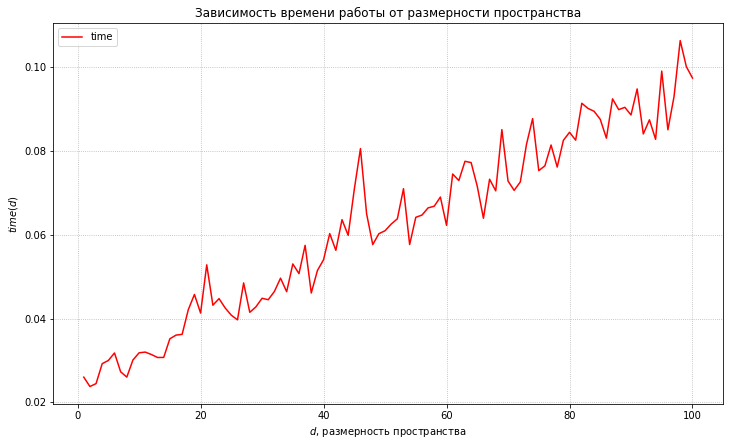

In [32]:
from timeit import default_timer as timer


T = 500
max_dimension = 100
dimension_grid = np.arange(max_dimension) + 1
times = np.zeros(max_dimension)

for i in range(max_dimension):
    dimension = dimension_grid[i]
    R = generate_table(dimension, T)
    # best_fixed_profit = calculate_fixed_profit(dimension)
    start_time = timer()
    our_profit = calculate_online_profit(dimension)
    times[i] = timer() - start_time
        
    
plt.figure(figsize=(12, 7))
plt.grid(ls=':')
plt.plot(dimension_grid, times, color='red', label='time')
plt.xlabel(r'$d$, размерность пространства')
plt.ylabel(r'$time(d)$')
plt.title('Зависимость времени работы от размерности пространства')
plt.legend()
plt.show()

Как и ожидалось, время работы зависит от размерности пространства линейно.